In [1]:
import pandas as pd

log_path = '../data/HDFS.log'
with open(log_path, 'r') as file:
    lines = file.readlines()

logs = pd.DataFrame(lines, columns=['log'])
logs.head()


,log
0,081111 032233 34 INFO dfs.FSNamesystem: BLOCK*...
1,081110 123023 11088 INFO dfs.DataNode$PacketRe...
2,081111 072459 34 INFO dfs.FSNamesystem: BLOCK*...
3,081111 023014 27 INFO dfs.FSNamesystem: BLOCK*...
4,081111 030004 18183 INFO dfs.DataNode$DataXcei...


In [2]:
import regex as re

# Функция для извлечения block_id
def extract_block_id(log_line):
    match = re.search(r'blk_-?\d+', log_line)
    return match.group(0) if match else None

logs['block_id'] = logs['log'].apply(extract_block_id)

logs.dropna(subset=['block_id'], inplace=True)
all_logs = logs['log'].unique()

logs.head()


,log,block_id
0,081111 032233 34 INFO dfs.FSNamesystem: BLOCK*...,blk_-5327725140452543501
1,081110 123023 11088 INFO dfs.DataNode$PacketRe...,blk_-8773898409706445615
2,081111 072459 34 INFO dfs.FSNamesystem: BLOCK*...,blk_-4329641471754524122
3,081111 023014 27 INFO dfs.FSNamesystem: BLOCK*...,blk_-390921607507384009
4,081111 030004 18183 INFO dfs.DataNode$DataXcei...,blk_-2967608524545562422


In [3]:
sessions = logs.groupby('block_id')['log'].apply(list).reset_index(name='sequence')

sessions.head()

,block_id,sequence
0,blk_-1000002529962039464,[081111 094454 25868 INFO dfs.DataNode$PacketR...
1,blk_-100000266894974466,[081110 020141 6105 INFO dfs.DataNode$PacketRe...
2,blk_-1000054577281647820,[081110 012531 5179 INFO dfs.DataNode$PacketRe...
3,blk_-1000245396392748444,[081110 002154 4817 INFO dfs.DataNode$PacketRe...
4,blk_-1000285592763698141,[081110 162157 13111 INFO dfs.DataNode$DataXce...


In [4]:

log2idx = {log: idx for idx, log in enumerate(all_logs)}

def fast_encode(seq):
    return [log2idx[log] for log in seq if log in log2idx]

sessions['encoded'] = sessions['sequence'].apply(fast_encode)

sessions.head()

,block_id,sequence,encoded
0,blk_-1000002529962039464,[081111 094454 25868 INFO dfs.DataNode$PacketR...,[242059]
1,blk_-100000266894974466,[081110 020141 6105 INFO dfs.DataNode$PacketRe...,[261783]
2,blk_-1000054577281647820,[081110 012531 5179 INFO dfs.DataNode$PacketRe...,[109530]
3,blk_-1000245396392748444,[081110 002154 4817 INFO dfs.DataNode$PacketRe...,[3086]
4,blk_-1000285592763698141,[081110 162157 13111 INFO dfs.DataNode$DataXce...,[86956]


In [ ]:
import numpy as np

window_size = 3  #было 5, но модель выдавала лосс 12.3-> 12.0 и было меньше обучающих примеров (200)

X = []
y = []

for encoded_seq in sessions['encoded']:
    if len(encoded_seq) > window_size:
        for i in range(len(encoded_seq) - window_size):
            X.append(encoded_seq[i:i+window_size])
            y.append(encoded_seq[i+window_size])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
# print((sessions['encoded'].apply(len) > 5).sum())

X shape: (3173, 3)
y shape: (3173,)
80


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class LogDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = LogDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMLogModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=256, dropout_rate= 0.3):
        super(LSTMLogModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout= nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        last_hidden = output[:, -1, :]
        out = self.fc(self.dropout(last_hidden))
        return out

vocab_size = len(log2idx)
model = LSTMLogModel(vocab_size).to(device)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/5 - Loss: 12.8260
Epoch 2/5 - Loss: 10.1237
Epoch 3/5 - Loss: 8.0760
Epoch 4/5 - Loss: 6.8203
Epoch 5/5 - Loss: 5.0914


In [9]:
import random
model.eval()

idx = random.randint(0, len(X) - 1)
test_seq = torch.tensor(X[idx]).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_seq)
    predicted_token = torch.argmax(output, dim=1).item()
    top_k = 5  
    topk_indices = torch.topk(output, k=top_k, dim=1).indices[0].tolist()

# Восстановим текст логов по индексам
input_logs = [log for log, ix in log2idx.items() if ix in X[idx]]
predicted_log = [log for log, ix in log2idx.items() if ix == predicted_token][0]
real_log = [log for log, ix in log2idx.items() if ix == y[idx]][0]

print(" Входная последовательность:")
for log in input_logs:
    print("-", log.strip())

print("\n Предсказанный следующий лог :")
print("-", predicted_log.strip())

print("\n Реальный лог:")
print("-", real_log.strip())

print("\n  топ 5 предсказаний:")
for i, ix in enumerate(topk_indices):
    log_txt = [log for log, log_ix in log2idx.items() if log_ix == ix][0]
    print(f"{i+1}. {log_txt.strip()}")

 Входная последовательность:
- 081111 060403 21415 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_2078963298428616229 terminating
- 081111 060323 21414 INFO dfs.DataNode$DataXceiver: Receiving block blk_2078963298428616229 src: /10.251.107.227:57741 dest: /10.251.107.227:50010
- 081111 060403 21620 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_2078963298428616229 terminating

 Предсказанный следующий лог :
- 081111 065210 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.delete: blk_2078963298428616229 is added to invalidSet of 10.251.107.227:50010

 Реальный лог:
- 081111 065210 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.delete: blk_2078963298428616229 is added to invalidSet of 10.251.107.227:50010

  топ 5 предсказаний:
1. 081111 065210 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.delete: blk_2078963298428616229 is added to invalidSet of 10.251.107.227:50010
2. 081111 023037 27 INFO dfs.FSNamesystem: BLOCK* NameSystem.delete: blk_-608153821407631206

In [10]:
def evaluate_top_k(model, X, y, top_k_list=[1, 3, 5]):
    model.eval()
    results = {k: 0 for k in top_k_list}
    total = len(X)

    with torch.no_grad():
        for i in range(total):
            x_input = torch.tensor(X[i]).unsqueeze(0).to(device)  # shape: [1, seq_len]
            target = y[i]

            logits = model(x_input)
            for k in top_k_list:
                topk = torch.topk(logits, k=k, dim=1).indices[0].tolist()
                if target in topk:
                    results[k] += 1

    for k in top_k_list:
        acc = results[k] / total * 100
        print(f" Accuracy@{k}: {acc:.2f}% ({results[k]}/{total})")

evaluate_top_k(model, X, y)

 Accuracy@1: 96.85% (3073/3173)
 Accuracy@3: 98.96% (3140/3173)
 Accuracy@5: 99.12% (3145/3173)


In [11]:
label_path = '../data/anomaly_label.csv'
labels_df = pd.read_csv(label_path)

print(labels_df.head())
print(labels_df.columns)

                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal
Index(['BlockId', 'Label'], dtype='object')


In [12]:
labels_df.columns = ['block_id', 'label']

labels_df['block_id'] = labels_df['block_id'].astype(str)
sessions['block_id'] = sessions['block_id'].astype(str)

sessions = sessions.merge(labels_df, on='block_id', how='inner')

# Преобразуем метки в числа: Normal = 0, Anomaly = 1
sessions['label'] = sessions['label'].map({'Normal': 0, 'Anomaly': 1})

sessions.head()

,block_id,sequence,encoded,label
0,blk_-1000002529962039464,[081111 094454 25868 INFO dfs.DataNode$PacketR...,[242059],0
1,blk_-100000266894974466,[081110 020141 6105 INFO dfs.DataNode$PacketRe...,[261783],0
2,blk_-1000054577281647820,[081110 012531 5179 INFO dfs.DataNode$PacketRe...,[109530],0
3,blk_-1000245396392748444,[081110 002154 4817 INFO dfs.DataNode$PacketRe...,[3086],0
4,blk_-1000285592763698141,[081110 162157 13111 INFO dfs.DataNode$DataXce...,[86956],0


In [13]:
# Преобразуем последовательности логов в текст
sessions['log_text'] = sessions['sequence'].apply(lambda seq: ' '.join(seq))

sessions[['log_text', 'label']].head()

,log_text,label
0,081111 094454 25868 INFO dfs.DataNode$PacketRe...,0
1,081110 020141 6105 INFO dfs.DataNode$PacketRes...,0
2,081110 012531 5179 INFO dfs.DataNode$PacketRes...,0
3,081110 002154 4817 INFO dfs.DataNode$PacketRes...,0
4,081110 162157 13111 INFO dfs.DataNode$DataXcei...,0


In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_sessions, test_sessions = train_test_split(
    sessions,
    test_size=0.2,
    stratify=sessions['label'],
    random_state=42
)


train_split, val_split = train_test_split(
    train_sessions,
    test_size=0.1,
    stratify=train_sessions['label'],
    random_state=42
)
print(" До oversampling:")
print(train_split['label'].value_counts())
print(f"Доля аномалий: {train_split['label'].value_counts(normalize=True)[1]:.2%}")

def soft_oversample(train_df, minority_label=1, multiplier=10):
    minority_df = train_df[train_df['label'] == minority_label]
    majority_df = train_df[train_df['label'] != minority_label]
    

    minority_oversampled = pd.concat([minority_df] * multiplier, ignore_index=True)
    

    balanced_train = pd.concat([majority_df, minority_oversampled], ignore_index=True)
    balanced_train = balanced_train.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    return balanced_train

train_split = soft_oversample(train_split)
print(" После oversampling:")
print(train_split['label'].value_counts())
print(f"Доля аномалий: {train_split['label'].value_counts(normalize=True)[1]:.2%}")

 До oversampling:
label
0    191759
1      4781
Name: count, dtype: int64
Доля аномалий: 2.43%
 После oversampling:
label
0    191759
1     47810
Name: count, dtype: int64
Доля аномалий: 19.96%


In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_split['label']),
    y=train_split['label']
)
scaled_weights = np.log1p(class_weights)

# weights_tensor = torch.tensor([1.0, 5.0], dtype=torch.float).to(device)
weights_tensor = torch.tensor(scaled_weights, dtype=torch.float).to(device)
print("Class weights:", weights_tensor)

Class weights: tensor([0.4853, 1.2543], device='cuda:0')


In [16]:
import random


def shuffle_logs(text, p=0.6):
    lines = text.strip().split('\n')
    if random.random() < p:
        random.shuffle(lines)
    return '\n'.join(lines)

def dropout_logs(text, drop_prob=0.3):
    logs = text.strip().split('\n')
    kept = [log for log in logs if random.random() > drop_prob]
    return '\n'.join(kept if kept else logs[:1])

log_synonyms = {
    "Task started": "Job initiated",
    "Connection failed": "Network error",
    "Job failed": "Execution error",
    "Service unavailable": "Endpoint unreachable"
}

def replace_synonyms(text):
    for k, v in log_synonyms.items():
        text = text.replace(k, v)
    return text


def clean_log_text(text):
    # Удалим IP-адреса
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '<IP>', text)
    # Удалим timestamps (6+ цифр подряд, как 081110 123023)
    text = re.sub(r'\b\d{6,}\b', '<NUM>', text)
    # Удалим короткие числа (например, порты, PID, размер блоков и т.д.)
    text = re.sub(r'\b\d{2,5}\b', '<NUM>', text)
    # Удалим block ids вида blk_-<число>
    text = re.sub(r'blk_[-]?\d+', '<BLOCK>', text)
    return text

train_sessions['log_text'] = train_split['log_text'].apply(
    lambda x: clean_log_text(replace_synonyms(dropout_logs(shuffle_logs(x))))
)

In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenized_train = tokenizer(
    train_split['log_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

tokenized_val = tokenizer(
    val_split['log_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

tokenized_test = tokenizer(
    test_sessions['log_text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

print(" Train  input_ids shape:", tokenized_train['input_ids'].shape)
print(" Val    input_ids shape:", tokenized_val  ['input_ids'].shape)
print(" Test   input_ids shape:", tokenized_test ['input_ids'].shape)

c:\Users\hasee\Desktop\dimplom\soc_ml_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Train  input_ids shape: torch.Size([239569, 256])
 Val    input_ids shape: torch.Size([21838, 256])
 Test   input_ids shape: torch.Size([54595, 256])


In [18]:
from torch.utils.data import Dataset, DataLoader
import torch

# Создаём класс Dataset для логов
class LogBERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

# метки в тензоры
train_labels = torch.tensor(train_split['label'].values)
val_labels   = torch.tensor(val_split  ['label'].values)
test_labels  = torch.tensor(test_sessions['label'].values)

# сами датасеты
train_dataset = LogBERTDataset(tokenized_train, train_labels)
val_dataset   = LogBERTDataset(tokenized_val,   val_labels)
test_dataset  = LogBERTDataset(tokenized_test,  test_labels)

# дата-лодеры с батчами 
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8)
test_loader  = DataLoader(test_dataset,  batch_size=8)

In [19]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print("Device count:", torch.cuda.device_count())

CUDA available: True
Device name: NVIDIA GeForce RTX 2060
Device count: 1


In [20]:
from transformers import BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # 0: Normal, 1: Anomaly
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("устройство:", device)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


устройство: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm  
from focal_loss.focal_loss import FocalLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau


# n_pos = (train_split['label'] == 1).sum()
# n_neg = (train_split['label'] == 0).sum()
# pos_weight = torch.tensor(n_neg / n_pos, device=device)

optimizer = AdamW(model.parameters(), lr=1e-5)
#weight = torch.tensor([1.0, 3.0]).to(device)
# criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)
criterion = FocalLoss(weights=weights_tensor, gamma=2.5, reduction='mean')
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',             # мы отслеживаем валид. F1 (или Recall)
    factor=0.5,             # LR ← LR * 0.5
    patience=1,             # ждать 1 эпоху без улучшения
)



Epoch 1/6 [TRAIN]: 100%|██████████| 29947/29947 [2:58:16<00:00,  2.80it/s]  


 Epoch 1 — Train Loss: 0.0881


Epoch 1/6 [VAL]: 100%|██████████| 2730/2730 [05:16<00:00,  8.63it/s]


 => Val best threshold 0.68, F1 0.3274, Precision 0.6071, Recall 0.2241 
Current LR: 1.00e-05
  New best model, saved. Best threshold now = 0.68


Epoch 2/6 [TRAIN]: 100%|██████████| 29947/29947 [2:59:51<00:00,  2.78it/s]  


 Epoch 2 — Train Loss: 0.0485


Epoch 2/6 [VAL]: 100%|██████████| 2730/2730 [05:14<00:00,  8.69it/s]


 => Val best threshold 0.70, F1 0.3186, Precision 0.3719, Recall 0.2787 
Current LR: 1.00e-05


Epoch 3/6 [TRAIN]: 100%|██████████| 29947/29947 [2:56:55<00:00,  2.82it/s]  


 Epoch 3 — Train Loss: 0.0263


Epoch 3/6 [VAL]: 100%|██████████| 2730/2730 [05:12<00:00,  8.75it/s]


 => Val best threshold 0.70, F1 0.3274, Precision 0.5019, Recall 0.2429 
Current LR: 1.00e-05
  New best model, saved. Best threshold now = 0.70


Epoch 4/6 [TRAIN]: 100%|██████████| 29947/29947 [2:55:45<00:00,  2.84it/s]  


 Epoch 4 — Train Loss: 0.0157


Epoch 4/6 [VAL]: 100%|██████████| 2730/2730 [05:05<00:00,  8.94it/s]


 => Val best threshold 0.73, F1 0.3325, Precision 0.4676, Recall 0.2580 
Current LR: 1.00e-05
  New best model, saved. Best threshold now = 0.73


Epoch 5/6 [TRAIN]: 100%|██████████| 29947/29947 [2:54:59<00:00,  2.85it/s]  


 Epoch 5 — Train Loss: 0.0102


Epoch 5/6 [VAL]: 100%|██████████| 2730/2730 [05:04<00:00,  8.95it/s]


 => Val best threshold 0.70, F1 0.3091, Precision 0.3812, Recall 0.2599 
Current LR: 1.00e-05


Epoch 6/6 [TRAIN]: 100%|██████████| 29947/29947 [2:55:13<00:00,  2.85it/s]  


 Epoch 6 — Train Loss: 0.0075


Epoch 6/6 [VAL]: 100%|██████████| 2730/2730 [05:08<00:00,  8.84it/s]


 => Val best threshold 0.76, F1 0.3386, Precision 0.4730, Recall 0.2637 
Current LR: 1.00e-05
  New best model, saved. Best threshold now = 0.76

*** Training done. Overall best val F1 = 0.3386 at threshold = 0.76 ***
   epoch  train_loss    val_f1  val_precision  val_recall  threshold       lr
0      1    0.088133  0.327373       0.607143    0.224105       0.68  0.00001
1      2    0.048488  0.318622       0.371859    0.278719       0.70  0.00001
2      3    0.026311  0.327411       0.501946    0.242938       0.70  0.00001
3      4    0.015662  0.332524       0.467577    0.258004       0.73  0.00001
4      5    0.010234  0.309071       0.381215    0.259887       0.70  0.00001
5      6    0.007540  0.338573       0.472973    0.263653       0.76  0.00001


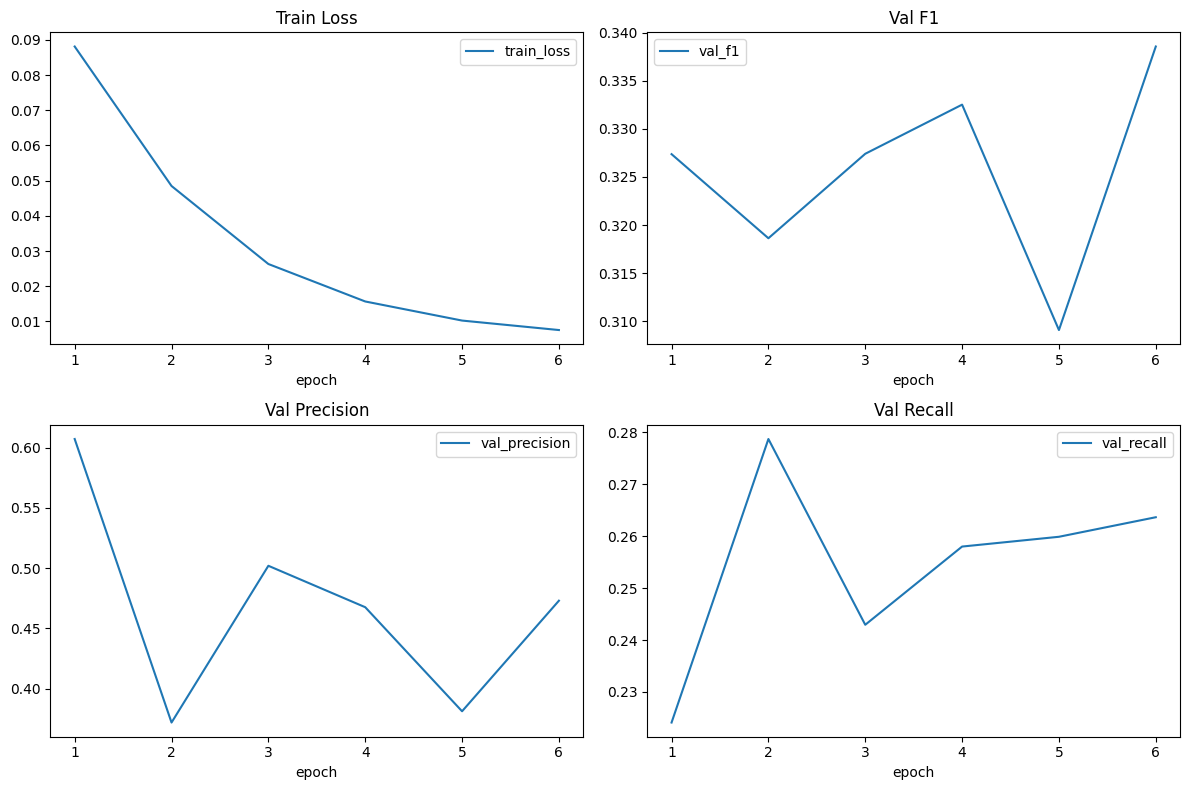

In [22]:
import os
from torch.nn.functional import softmax
import numpy as np
from sklearn.metrics import  f1_score, precision_score, recall_score


epochs = 6  
os.makedirs("saved_models", exist_ok=True)

best_val_f1 = 0.0
best_threshold = 0.5  

history = {
    'epoch': [],
    'train_loss': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': [],
    'threshold': [],
    'lr': []
}

# model.load_state_dict(torch.load("saved_models/bert_best_val.pt"))
# model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]"):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        probs   = softmax(outputs.logits, dim=1)
        loss    = criterion(probs, labels)
        # logits_pos   = outputs.logits[:, 1]           # shape [B,]
        # labels_float = labels.float()                 # из {0,1} → float
        # loss         = criterion(logits_pos, labels_float)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f" Epoch {epoch+1} — Train Loss: {avg_train_loss:.4f}")

    model.eval()
    val_logits = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [VAL]"):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs   = softmax(outputs.logits, dim=1)[:,1]  # P(anomaly)
            val_logits.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # подбор best_threshold по F1 на валидации
    
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = []
    for thr in thresholds:
        preds = (np.array(val_logits) >= thr).astype(int)
        f1s.append(f1_score(val_labels, preds, zero_division=0))
    idx = int(np.argmax(f1s))
    epoch_best_thr = thresholds[idx]
    epoch_best_f1 = f1s[idx]

    best_preds = (np.array(val_logits) >= epoch_best_thr).astype(int)
    epoch_precision = precision_score(val_labels, best_preds, zero_division=0)
    epoch_recall    = recall_score   (val_labels, best_preds, zero_division=0)

    print(f" => Val best threshold {epoch_best_thr:.2f}, F1 {epoch_best_f1:.4f}, Precision {epoch_precision:.4f}, Recall {epoch_recall:.4f} ")

    scheduler.step(epoch_best_f1)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current LR: {current_lr:.2e}")

    # Сохраняем, если лучше
    if epoch_best_f1 > best_val_f1:
        best_val_f1   = epoch_best_f1
        best_threshold = epoch_best_thr
        torch.save(model.state_dict(), "saved_models/bert_best_val.pt")
        print(f"  New best model, saved. Best threshold now = {best_threshold:.2f}")

    history['epoch'].append(epoch+1)
    history['train_loss'].append(avg_train_loss)
    history['val_f1'].append(epoch_best_f1)
    history['val_precision'].append(epoch_precision)
    history['val_recall'].append(epoch_recall)
    history['threshold'].append(epoch_best_thr)
    history['lr'].append(current_lr)

print(f"\n*** Training done. Overall best val F1 = {best_val_f1:.4f} at threshold = {best_threshold:.2f} ***")

df_hist = pd.DataFrame(history)
print(df_hist)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
df_hist.plot(x='epoch', y='train_loss',    ax=axs[0,0], title='Train Loss')
df_hist.plot(x='epoch', y='val_f1',        ax=axs[0,1], title='Val F1')
df_hist.plot(x='epoch', y='val_precision', ax=axs[1,0], title='Val Precision')
df_hist.plot(x='epoch', y='val_recall',    ax=axs[1,1], title='Val Recall')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Загружаем лучший вес и фиксируем threshold
model.load_state_dict(torch.load("saved_models/bert_best_val.pt"))
model.to(device)
thr = best_threshold


model.eval()
test_logits = []
test_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs   = softmax(outputs.logits, dim=1)[:,1]
        test_logits.extend(probs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

preds = (np.array(test_logits) >= thr).astype(int)
precision = precision_score(test_labels, preds, zero_division=0)
recall    = recall_score(test_labels, preds, zero_division=0)
f1        = f1_score(test_labels, preds, zero_division=0)
cm        = confusion_matrix(test_labels, preds)

print(f"\n Test results at threshold={thr:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)


Testing: 100%|██████████| 6825/6825 [12:50<00:00,  8.85it/s]



 Test results at threshold=0.76
Precision: 0.4392
Recall:    0.2395
F1 Score:  0.3099
Confusion Matrix:
[[52861   406]
 [ 1010   318]]


Собираем логиты: 100%|██████████| 6825/6825 [12:51<00:00,  8.85it/s]


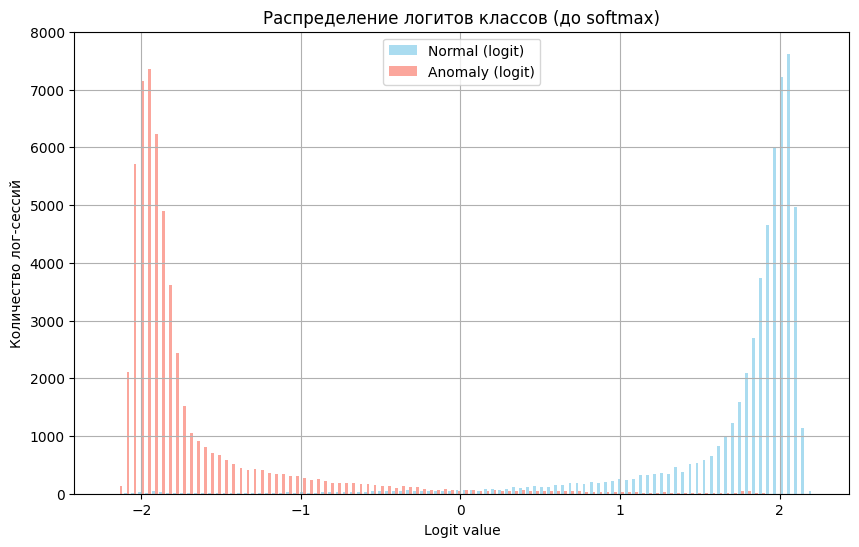

In [24]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

logits_class0 = []
logits_class1 = []
labels_all = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Собираем логиты"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        logits_class0.extend(logits[:, 0].cpu().numpy())  # логиты класса 0
        logits_class1.extend(logits[:, 1].cpu().numpy())  # логиты класса 1
        labels_all.extend(labels.cpu().numpy())


plt.figure(figsize=(10, 6))
plt.hist([logits_class0, logits_class1], bins=100, label=['Normal (logit)', 'Anomaly (logit)'], color=['skyblue', 'salmon'], alpha=0.7)
plt.title("Распределение логитов классов (до softmax)")
plt.xlabel("Logit value")
plt.ylabel("Количество лог-сессий")
plt.legend()
plt.grid(True)
plt.show()

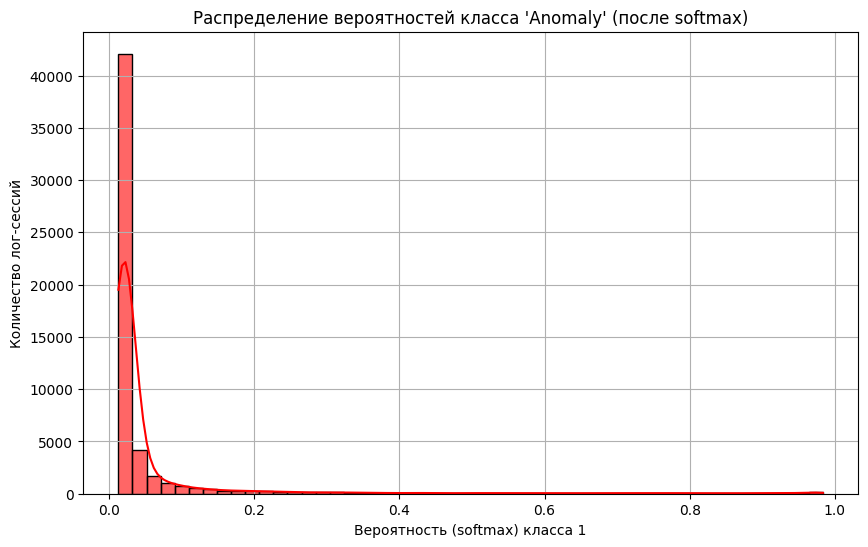

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import softmax
from tqdm import tqdm

model.eval()
anomaly_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting anomaly probabilities"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = softmax(outputs.logits, dim=1)
        anomaly_probs.extend(probs[:, 1].cpu().numpy())  


plt.figure(figsize=(10, 6))
sns.histplot(anomaly_probs, bins=50, kde=True, color='red', alpha=0.6)
plt.title("Распределение вероятностей класса 'Anomaly' (после softmax)")
plt.xlabel("Вероятность (softmax) класса 1")
plt.ylabel("Количество лог-сессий")
plt.grid(True)
plt.show()

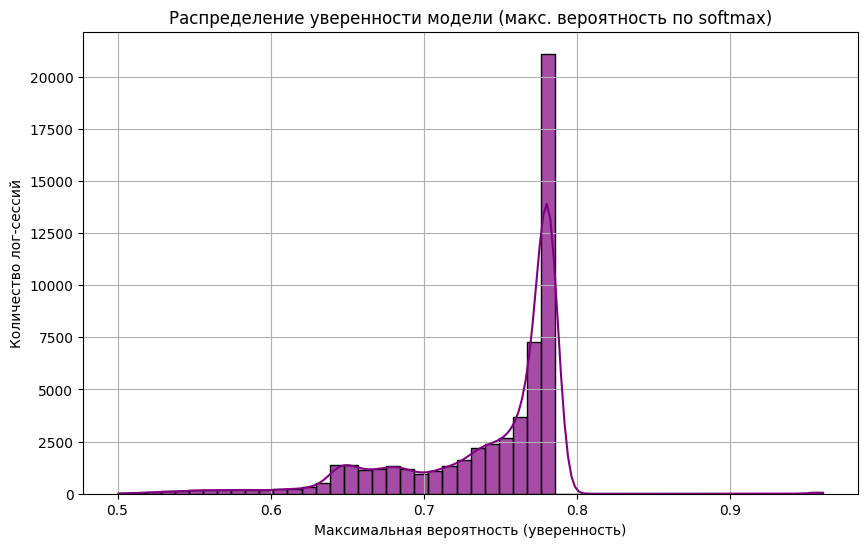

In [26]:
import torch
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Загружаем модель
model.load_state_dict(torch.load("saved_models/bert_focal_epoch3.pt"))
model.eval()
model.to(device)

max_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting confidences"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = softmax(outputs.logits, dim=1)

        # Сохраняем максимальную вероятность (уверенность)
        max_probs.extend(torch.max(probs, dim=1).values.cpu().numpy())

# Визуализация
plt.figure(figsize=(10, 6))
sns.histplot(max_probs, bins=50, kde=True, color='purple', alpha=0.7)
plt.title("Распределение уверенности модели (макс. вероятность по softmax)")
plt.xlabel("Максимальная вероятность (уверенность)")
plt.ylabel("Количество лог-сессий")
plt.grid(True)
plt.show()